<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/summarization/Langchain_GTR_T5_Large_Document_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.0 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install sentence-transformers spacy langchain trl datasets pypdf -qqq --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.document_loaders import DirectoryLoader, TextLoader

# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model


# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans


#splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=30, tokens_per_chunk=512, model_name= "sentence-transformers/gtr-t5-large")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests

response = requests.get("https://www.gutenberg.org/cache/epub/64317/pg64317.txt")

In [ ]:
book_complete_text = response.text

In [ ]:
book_complete_text = book_complete_text[5:]

In [ ]:
len(book_complete_text)

296884

In [ ]:
file_path = "/content/drive/MyDrive/data/book.txt"

In [ ]:
with open(file_path, "w", encoding="utf-8") as f:
    f.write(book_complete_text)

In [ ]:

with open(file_path, "r",  encoding="utf-8") as f:
    text = f.read()

In [ ]:
text = text.replace('\t', ' ')

In [ ]:
len(text)

290101

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=12000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])

In [ ]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 32 documents


In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)




vectors = embeddings.embed_documents([x.page_content for x in docs])

In [ ]:
len(vectors[0])

768

In [ ]:
num_clusters = int(len(vectors) // 4)
num_clusters

8

In [ ]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 5 if num_clusters <=5 else num_clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [ ]:
kmeans.labels_

array([0, 2, 3, 1, 1, 1, 1, 1, 3, 4, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       2, 4, 3, 3, 1, 3, 3, 5, 0, 7], dtype=int32)

In [ ]:
len(kmeans.labels_)

32

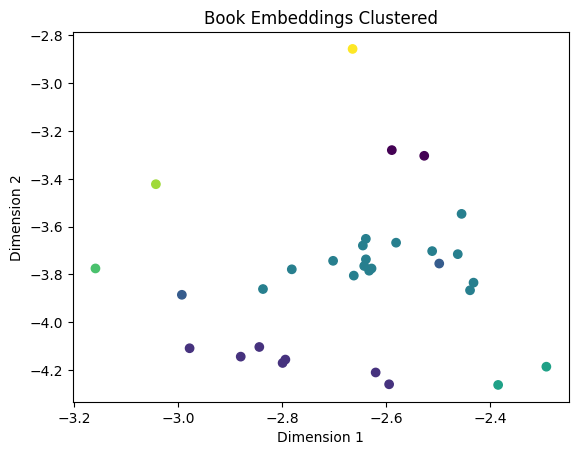

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [ ]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [ ]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 1, 5, 9, 11, 16, 29, 31]

In [ ]:
# Import libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import transformers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, GPT2LMHeadModel, AutoTokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, LongT5ForConditionalGeneration

# dataset = load_dataset("scientific_papers", "pubmed", split="validation")
model = (
    LongT5ForConditionalGeneration.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")#,  torch_dtype=torch.float16)
    .to("cuda")

)
tokenizer = AutoTokenizer.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")


# def generate_answers(batch):
#     inputs_dict = tokenizer(
#         batch["article"], max_length=16384, padding="max_length", truncation=True, return_tensors="pt"
#     )
#     input_ids = inputs_dict.input_ids.to("cuda")
#     attention_mask = inputs_dict.attention_mask.to("cuda")
#     output_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=512, num_beams=2)
#     batch["predicted_abstract"] = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
#     return batch


# result = dataset.map(generate_answer, batched=True, batch_size=2)
# rouge = evaluate.load("rouge")
# rouge.compute(predictions=result["predicted_abstract"], references=result["abstract"])

In [ ]:
# define tokenizer
# tokenizer = AutoTokenizer.from_pretrained("gpt2-medium", model_max_length = 1024)

# # define model
# # model = AutoModelForSeq2SeqLM.from_pretrained("gpt2-medium")
# model = GPT2LMHeadModel.from_pretrained('gpt2-medium', pad_token_id=tokenizer.eos_token_id)

In [ ]:
text_summarization_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="summarization",
    max_length = 512,
    do_sample=True,
    top_k =5,
    num_beams = 4,
    device_map= "auto",

)
llm = HuggingFacePipeline(pipeline=text_summarization_pipeline)

The model 'MistralForCausalLM' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


In [ ]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [ ]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [ ]:
selected_docs = [docs[doc] for doc in selected_indices]

In [ ]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:500]} \n")

/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [2856], which does not match the required output shape [1, 2856]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 23, 128, 1], which does not match the required output shape [1, 23, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #0 (chunk #0) - Preview: the great gatsby is a novel novel , and it is a novel novel . it is based on a single passage of a book . this article will be given a single passage of a book . this article will be enclosed in triple backticks (  ) the goal is to give a summary of this section so that a reader will have a full understanding of what happened . in this article , we will give a single passage of a book . this article will be enclosed in triple backticks (  ) the goal is to give a summary of this section so that a 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3147], which does not match the required output shape [1, 3147]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 25, 128, 1], which does not match the required output shape [1, 25, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #1 (chunk #1) - Preview: this article describes the history of the summer that occurred on the evening of a warm windy evening in the summer of 2010 . two young women were buoyed up as though upon an anchored balloon . they were both in white and their dresses were rippling and fluttering as if they had just been blown back in after a short flight around the house . two young women were buoyed up as though upon an anchored balloon . they were both in white and their dresses were rippling and fluttering as if they had ju 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3327], which does not match the required output shape [1, 3327]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 26, 128, 1], which does not match the required output shape [1, 26, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #2 (chunk #5) - Preview: the authors describe the case of a young woman who was found to have an inexhaustible variety of life . the patient was found to have a family history of a man who had undergone a work in the garage . the patient was found to have a family history of a woman who had been married to her wife , and her wife was shrill , languid , and awful . the patient was found to have an inexhaustible variety of life , and she was found to have an inexhaustible variety of life . the patient was found to have an 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3083], which does not match the required output shape [1, 3083]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 25, 128, 1], which does not match the required output shape [1, 25, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #3 (chunk #9) - Preview: this article describes a case of a man in a long duster who had dismounted from the wreck and now stood in the middle of the road , looking from the car to the tyre and from the tyre to the observers in a pleasant , puzzled way . a man in a long duster had dismounted from the wreck and now stood in the middle of the road and from the tyre to the observers in a pleasant , puzzled way . a man in a long duster had dismounted from the wreck and now stood in the middle of the road and from the tyre t 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3495], which does not match the required output shape [1, 3495]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 28, 128, 1], which does not match the required output shape [1, 28, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #4 (chunk #11) - Preview: this article presents a single passage of a book in a new york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york york yo 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3244], which does not match the required output shape [1, 3244]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 26, 128, 1], which does not match the required output shape [1, 26, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #5 (chunk #16) - Preview: this article describes the history of a young man who was found to have a family history of a young man who had been travelling along the south shore of lake superior for five years . this was a halt in my association with his affairs . this was a halt in my association with his affairs . this was a halt in my association with his affairs . this was a halt in my association with his affairs , and it was a halt in my association with his affairs . 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [3067], which does not match the required output shape [1, 3067]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 24, 128, 1], which does not match the required output shape [1, 24, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #6 (chunk #29) - Preview: the project gutenberg program is a web - based program that is designed to promote the free distribution of electronic works by using or distributing it in the united states without permission and without paying copyright royalties . it is a registered trademark and may not be used if you charge for an eBook , except by following the terms of the trademark license , including paying royalties for use of the project gutenberg trademark . 



/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:170: UserWarning: An output with one or more elements was resized since it had shape [2243], which does not match the required output shape [1, 2243]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  true_block_ends = torch.logical_and(block_ends, block_ids >= 0)
/usr/local/lib/python3.10/dist-packages/transformers/models/longt5/modeling_longt5.py:146: UserWarning: An output with one or more elements was resized since it had shape [1, 18, 128, 1], which does not match the required output shape [1, 18, 128, 384]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out te

Summary #7 (chunk #31) - Preview: the project gutenberg literary archivee foundation is a non - nonprofit 501(c)(3) educational corporation organized under the laws of the state of Mississippi and granted tax exempt status by the internal revenue service . the project gutenberg literary archivee foundation is a non - nonprofit 501(c)(3) educational corporation organized under the laws of the state of Mississippi and granted tax exempt status by the internal revenue service . the project gutenberg literary archivee foundation is  



In [ ]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 2923 tokens


In [ ]:
print(summaries.page_content)

the great gatsby is a novel novel , and it is a novel novel . it is based on a single passage of a book . this article will be given a single passage of a book . this article will be enclosed in triple backticks (  ) the goal is to give a summary of this section so that a reader will have a full understanding of what happened . in this article , we will give a single passage of a book . this article will be enclosed in triple backticks (  ) the goal is to give a summary of this section so that a reader will have a full understanding of what happened . in addition , we will give a summary of this section so that a reader will have a full understanding of what happened . in addition , we will give a summary of this section so that a reader will have a full understanding of what happened . in addition , we will give a summary of this section so that a reader will have a full understanding of what happened . in addition , we will give a summary of this section so that a reader will have a 

In [ ]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS


# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=5000, chunk_overlap=1000)

docs = text_splitter.create_documents([text])

In [ ]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 74 documents


In [ ]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

# Map
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

In [ ]:
# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes.
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [ ]:
ChatPromptTemplate(input_variables=['docs'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'))])

ChatPromptTemplate(input_variables=['docs'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'))])

In [ ]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=1024,
)

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
text[:1300]

'\ufeffThe Project Gutenberg eBook of The Great Gatsby\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org. If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.\n\nTitle: The Great Gatsby\n\n\nAuthor: F. Scott Fitzgerald\n\nRelease date: January 17, 2021 [eBook #64317]\n                Most recently updated: February 2, 2024\n\nLanguage: English\n\nCredits: Produced by Alex Cabal for the Standard Ebooks project, based on a transcription produced for Project Gutenberg Australia.\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY ***\n\n\n\n\n                           The Great Gatsby\n                                  by\n        

In [ ]:
len(text)

290106

In [ ]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 82477 tokens in it


In [ ]:
#%pip install --upgrade --quiet  tiktoken

In [ ]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.text_splitter import CharacterTextSplitter

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1200, chunk_overlap=20
)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", " "], chunk_size=8192, chunk_overlap=30, length_function=len,)

docs = text_splitter.create_documents([text])

In [ ]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 37 documents


In [ ]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
    verbose = True,
)


split_docs = text_splitter.split_documents(docs)

In [ ]:
%%time
output = map_reduce_chain.invoke(split_docs)

Token indices sequence length is longer than the specified maximum sequence length for this model (1839 > 512). Running this sequence through the model will result in indexing errors




> Entering new MapReduceDocumentsChain chain...


Your max_length is set to 800, but your input_length is only 452. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=226)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to

KeyboardInterrupt: 

In [ ]:
output['output_text']

'Love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, love, lov

In [ ]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

# Define prompt
prompt_template = """Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

In [ ]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")


print(stuff_chain.run(docs))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Token indices sequence length is longer than the specified maximum sequence length for this model (91142 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
embeddings = HuggingFaceEmbeddings()

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [ ]:
len(vectors[0])

1024

In [ ]:
vectors[0]

[-0.0246950164437294,
 -0.049805961549282074,
 0.013617407530546188,
 0.006391843780875206,
 0.016294404864311218,
 0.04171421751379967,
 0.09312186390161514,
 0.07349852472543716,
 -0.054893434047698975,
 -0.0396709069609642,
 0.22199657559394836,
 -0.00904484000056982,
 -0.03472462669014931,
 0.015074074268341064,
 -0.00399515638127923,
 0.005794224329292774,
 -0.04130904749035835,
 -0.05434015765786171,
 0.001101319445297122,
 0.11893370002508163,
 -0.016603508964180946,
 0.26355719566345215,
 -0.02930924855172634,
 -0.01956118643283844,
 -0.02051701955497265,
 -0.03630324453115463,
 -0.007647854741662741,
 -0.05820630490779877,
 -0.016669228672981262,
 0.012905185110867023,
 0.027155708521604538,
 0.008759928867220879,
 -0.03157742694020271,
 0.05758325010538101,
 -0.03561120107769966,
 -0.021108321845531464,
 -0.057831332087516785,
 -0.03785552829504013,
 0.05429385229945183,
 0.0531940832734108,
 -0.05333776772022247,
 -0.0110468789935112,
 0.07530857622623444,
 0.036324236541986

In [ ]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 21

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [ ]:
kmeans.labels_

array([19,  3,  9,  9,  9,  9,  9,  4,  0, 14,  3,  9,  0, 14,  0,  9, 14,
       18, 18,  5,  5, 18, 18, 18,  6,  6, 15, 17,  7, 18,  6,  1,  1, 17,
       17, 17,  7,  5, 15,  6,  6,  8,  7,  6,  6,  6,  9, 14,  5, 14, 14,
       13, 13, 15, 18,  7,  6, 14,  7,  7,  7, 14, 13, 13, 18, 18, 18,  7,
        7,  6,  6,  6,  6,  6,  6,  3,  1,  7, 17,  5,  7, 14, 14, 20, 20,
        3, 13, 13, 15,  1, 15,  6,  6,  1, 18, 15,  6,  6, 14, 15,  6, 18,
        6,  1, 17, 18, 15, 18, 18, 15,  1, 17, 17,  7, 17, 17,  8,  8, 13,
       11, 20,  3, 13,  3,  6,  1,  3,  3, 16, 16, 16, 16, 16,  4, 18, 18,
        1,  1,  9,  0,  3,  3,  1,  3, 17,  3,  8,  8,  7,  7,  6,  7,  6,
        6,  7,  6,  6,  7,  4, 13,  1, 13,  3,  7, 13,  1,  3,  8,  1,  6,
        1,  3,  7,  6,  6,  6, 15, 15, 15,  5,  7,  5, 15, 15,  6, 14,  5,
       18,  7,  6,  6, 11, 14, 18, 18,  8,  8,  1,  7,  7,  7,  7,  7,  9,
        1, 13,  3,  0,  9,  0, 11,  0,  0,  3,  3,  8, 15,  6,  6,  6,  6,
       17,  9,  7,  7, 15

In [ ]:
len(kmeans.labels_)

414

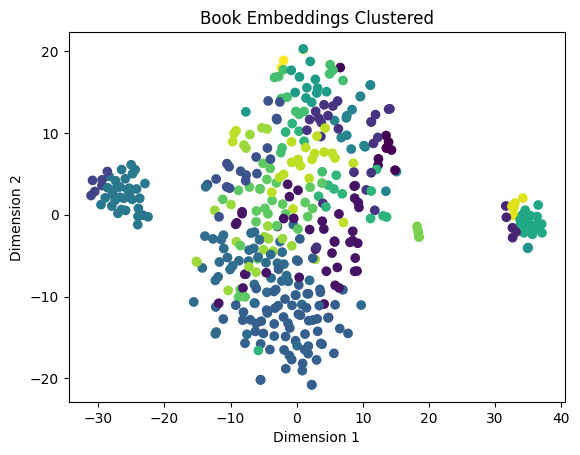

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [ ]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [ ]:
selected_indices = sorted(closest_indices)
selected_indices

[38,
 44,
 66,
 84,
 129,
 133,
 179,
 185,
 203,
 212,
 232,
 238,
 303,
 328,
 343,
 345,
 361,
 391,
 400,
 404,
 412]

In [ ]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [ ]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [ ]:
selected_docs = [docs[doc] for doc in selected_indices]

In [ ]:
selected_docs[0]

Document(page_content='The horses, needless to say, were not mentioned again. Tom and Miss\nBaker, with several feet of twilight between them, strolled back into\nthe library, as if to a vigil beside a perfectly tangible body, while,\ntrying to look pleasantly interested and a little deaf, I followed\nDaisy around a chain of connecting verandas to the porch in front. In\nits deep gloom we sat down side by side on a wicker settee.\n\nDaisy took her face in her hands as if feeling its lovely shape, and\nher eyes moved gradually out into the velvet dusk. I saw that\nturbulent emotions possessed her, so I asked what I thought would be\nsome sedative questions about her little girl.\n\n“We don’t know each other very well, Nick,” she said suddenly. “Even\nif we are cousins. You didn’t come to my wedding.”\n\n“I wasn’t back from the war.”\n\n“That’s true.” She hesitated. “Well, I’ve had a very bad time, Nick,\nand I’m pretty cynical about everything.”')

In [ ]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[-250:]} \n")

Summary #0 (chunk #38) - Preview: a reader will be given a single passage of a book. your goal is to give a summary of this section . your response should be at least three paragraphs and fully encompass what was said in the passage . 

Summary #1 (chunk #44) - Preview: daisy and tom looked at each other for a moment in silence . “did you give Nick a little heart to heart talk on the veranda?” demanded Tom suddenly . your goal is to give a summary of this section so that a reader will have a full understanding . 

Summary #2 (chunk #66) - Preview: your goal is to give a summary of this section so that a reader will have a full understanding of what happened . your response should be at least three paragraphs and fully encompass what was said in the passage. 

Summary #3 (chunk #84) - Preview:  be enclosed in triple backticks () your goal is to give a summary of this section so that a reader will have a full understanding of what happened . your response should be at least three paragra

KeyboardInterrupt: 

In [ ]:
summary_list[0]

"cnn's john sutter recalls his climb of mount everest in 1996 . he says the climb was hampered by low atmospheric pressure . the climbers, he writes, were unable to escape the mountain's treacherous terrain ."

In [ ]:
len(summary_list)

21

In [ ]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 1421 tokens


In [ ]:
text_summarization_pipeline2 = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="summarization",
    temperature=0.2,
    repetition_penalty=1.1,
      max_new_tokens=1000,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,

)
llm2 = HuggingFacePipeline(pipeline=text_summarization_pipeline2)

In [ ]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [ ]:
reduce_chain = load_summarize_chain(llm=llm2,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                             verbose=True # Set this to true if you want to see the inner workings
                                   )

In [ ]:
output = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```cnn's john sutter recalls his climb of mount everest in 1996 . he says the climb was hampered by low atmospheric pressure . the climbers, he writes, were unable to escape the mountain's treacherous terrain .
james moore: climbing has become the focus of his life, but he abandoned his dream of climbing everest . he says a decade ago, a pair of u.s. climbers reached the summit of the world's tallest mountain . now, he writes, climbing is a way of life for many, but it's also a money-making venture . author: if you want to climb everest, you have to take time away from your job .
cnn's john defterios meets the man who guided him to the top of

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



> Finished chain.

> Finished chain.


In [ ]:
print (output)

bob greene says he was given a passage from a book and asked to give a verbose summary of what happened in the story . john sutter recalls his climb of everest in 1996 . dean obeidallah says a journalist's presence on the expedition may have contributed to disaster .
